# Import all packages and set paths and environment attributes

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import gc
import json

#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress TF debug message spam in v2.12

from tensorflow import config as tf_config
# Only needed for tensorflow versions greater than 2.16.0
import sys
import joblib
sys.path.insert(1,"../")

import yaml
from pathlib import Path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import numpy as np
import pandas as pd

from config import set_gpu_mode

import setupdata
import setupmodel
from data import all_fcst_fields
from evaluation import evaluate_multiple_checkpoints


2025-09-23 00:02:33.616018: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 00:02:33.672416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 00:02:34.815631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check whether GPU is available or not

In [2]:
gpu_devices = tf_config.list_physical_devices('GPU')
    
print(gpu_devices)
    
if len(gpu_devices) == 0:
    print('GPU devices are not being seen')

[]
GPU devices are not being seen


# Load in configuration files for this you need to specify the path to the configuration file to use, typically this will be config/config.yaml

## Please refer to the README under [model/](https://github.com/snath-xoc/cGAN_tutorial/tree/main/model) for information. Most importantly the model configuration will specify:
### 1) mode: between GAN, VAEGAN and det <br> 2) arch: between forceconv, forceconv-long and normal <br> 3) filters_gen and filters_disc: width of generator and discriminator network <br> 4) lr_gen and lr_disc: learning rate for generator and discriminator <br> 5) train_years and val_years: training and validation years to use <br> 6) num_samples: no. of samples to train on <br> 7) steps_per_checkpoint: number of batches per checkpoint save <br> 8) batch_size: size of batches <br> 9) CLtype: between CRPS, CRPS_phys, ensmeanMSE, ensmeanMSE_phys <br> 10) content_loss_weight: how much to weight content loss in loss calculation <br> 11) training_weights: training weights to assign when sampling each bin used in tfrecord creation

In [3]:
# Path to config
config_path = "../config/config.yaml"

with open(config_path, "r") as f:
    try:
        setup_params = yaml.safe_load(f)
        # print(setup_params)
    except yaml.YAMLError as exc:
        print(exc)

mode = setup_params["GENERAL"]["mode"]
arch = setup_params["MODEL"]["architecture"]
padding = setup_params["MODEL"]["padding"]
log_folder = setup_params["SETUP"]["log_folder"]
problem_type = setup_params["GENERAL"]["problem_type"]
filters_gen = setup_params["GENERATOR"]["filters_gen"]
lr_gen = setup_params["GENERATOR"]["learning_rate_gen"]
noise_channels = setup_params["GENERATOR"]["noise_channels"]
latent_variables = setup_params["GENERATOR"]["latent_variables"]
filters_disc = setup_params["DISCRIMINATOR"]["filters_disc"]
lr_disc = setup_params["DISCRIMINATOR"]["learning_rate_disc"]
train_years = setup_params["TRAIN"]["train_years"]
training_weights = setup_params["TRAIN"]["training_weights"]
num_samples = setup_params["TRAIN"]["num_samples"]
steps_per_checkpoint = setup_params["TRAIN"]["steps_per_checkpoint"]
batch_size = setup_params["TRAIN"]["batch_size"]
kl_weight = setup_params["TRAIN"]["kl_weight"]
ensemble_size = setup_params["TRAIN"]["ensemble_size"]
CLtype = setup_params["TRAIN"]["CL_type"]
content_loss_weight = setup_params["TRAIN"]["content_loss_weight"]
val_years = setup_params["VAL"]["val_years"]
val_size = setup_params["VAL"]["val_size"]
num_images = setup_params["EVAL"]["num_batches"]
add_noise = setup_params["EVAL"]["add_postprocessing_noise"]
noise_factor = setup_params["EVAL"]["postprocessing_noise_factor"]
max_pooling = setup_params["EVAL"]["max_pooling"]
avg_pooling = setup_params["EVAL"]["avg_pooling"]
constant_fields = 2  # future todo: have dataset config file?

# otherwise these are of type string, e.g. '1e-5'
lr_gen = float(lr_gen)
lr_disc = float(lr_disc)
kl_weight = float(kl_weight)
noise_factor = float(noise_factor)
content_loss_weight = float(content_loss_weight)

print("Loaded in the configuration for model training from:", config_path)
print("\n Model details are as follows,\n mode:",mode, "\n arch:", arch, "\n filters_gen:", filters_gen, "\n filters_disc:", filters_disc)
print("\n Training details are as follows,\n lr_gen:", lr_gen, "\n lr_disc:", lr_disc, "\n train_years:", train_years, "\n val_years:", val_years, 
     "\n CLtype:", CLtype, "\n content_loss_weight:", content_loss_weight)
print("\n During training the following protocol will be used, \n num_samples:", num_samples, "\n steps_per_checkpoint:", steps_per_checkpoint,
      "\n batch_size:", batch_size, "\n training_weights:", training_weights)


Loaded in the configuration for model training from: ../config/config.yaml

 Model details are as follows,
 mode: GAN 
 arch: forceconv 
 filters_gen: 128 
 filters_disc: 512

 Training details are as follows,
 lr_gen: 0.0001 
 lr_disc: 0.0001 
 train_years: [2018] 
 val_years: 2018 
 CLtype: ensmeanMSE 
 content_loss_weight: 1000.0

 During training the following protocol will be used, 
 num_samples: 640000 
 steps_per_checkpoint: 9600 
 batch_size: 2 
 training_weights: [0.4, 0.3, 0.2, 0.1]


## Set up data by calling [setupdata.setup_data](https://github.com/snath-xoc/cGAN_tutorial/blob/main/setupdata.py#L42), this will return:
### 1) batch_gen_train: training dataset created by sampling from tfrecords according to the training weights <br> 2) data_gen_valid: validation dataset of full images to validate over the whole domain

In [4]:
batch_gen_train, data_gen_valid = setupdata.setup_data(
            train_years=train_years,
            val_years=val_years,
            autocoarsen=False,
            weights=training_weights,
            batch_size=batch_size)

## Once again check output of validation dataset

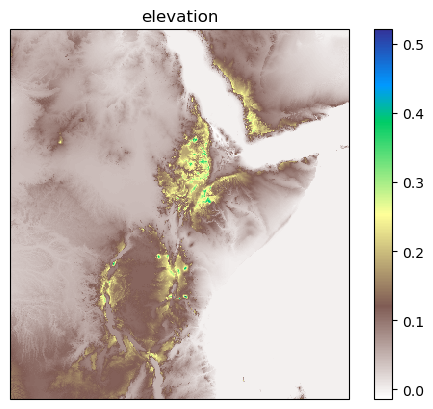

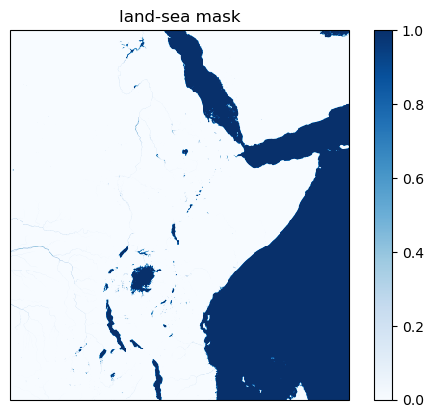

Text(0.5, 1.0, 'sp mean')

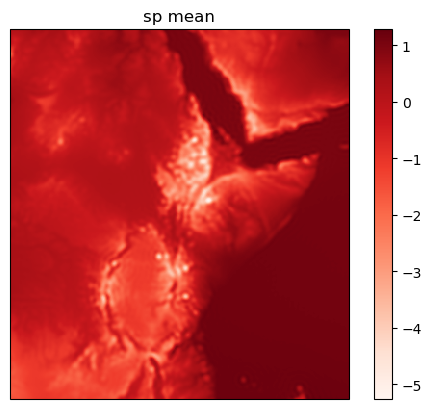

In [5]:
sample = data_gen_valid.__getitem__(0)
ax = plt.axes(projection = ccrs.PlateCarree())

lats = np.arange(-13.65,24.65+0.1,0.1)
lons = np.arange(19.15,54.25+0.1,0.1)

mesh = ax.pcolormesh(lons, lats, sample[0]['hi_res_inputs'][0,:,:,0], cmap='terrain_r')
plt.colorbar(mesh)
plt.title('elevation')
plt.show()
plt.close()

ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(lons, lats, sample[0]['hi_res_inputs'][0,:,:,1], cmap='Blues')
plt.colorbar(mesh)
plt.title('land-sea mask')
plt.show()
plt.close()

idx = 4 * all_fcst_fields.index("sp")
ax = plt.axes(projection = ccrs.PlateCarree())

lats = np.arange(-13.65,24.65+0.1,0.1)
lons = np.arange(19.15,54.25+0.1,0.1)

mesh = ax.pcolormesh(lons, lats, sample[0]['lo_res_inputs'][0,:,:,idx], cmap='Reds')
plt.colorbar(mesh)
plt.title(f"sp mean")



## Now set up model for training, before doing so we also need to:
### 1) Specify the downscaling factor with which the model will work. This is set in the [config/downscaling_factor.yaml](https://github.com/snath-xoc/cGAN_tutorial/blob/main/config/downscaling_factor.yaml) and is loaded in by calling ```read_downscaling_factor```<br> 2) Calculate the number of input channels which will be number of ```all_fcst_fields*4``` (see [create_tfrecords.ipynb](https://github.com/snath-xoc/cGAN_tutorial/blob/main/example_notebooks/create_tfrecords.ipynb) for more explanation)

In [6]:
from config import read_downscaling_factor

df_dict = read_downscaling_factor()

print("Downscaling factor to be used is:", df_dict["downscaling_factor"], "with steps:", df_dict["steps"])

input_channels = 4 * len(all_fcst_fields)

print("Number of input channels are:", input_channels)

Downscaling factor to be used is: 1 with steps: [1]
Number of input channels are: 56


In [7]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
print("Setting up model")

model = setupmodel.setup_model(
            mode=mode,
            arch=arch,
            downscaling_steps=df_dict["steps"],
            input_channels=input_channels,
            constant_fields=constant_fields,
            latent_variables=latent_variables,
            filters_gen=filters_gen,
            filters_disc=filters_disc,
            noise_channels=noise_channels,
            padding=padding,
            lr_disc=lr_disc,
            lr_gen=lr_gen,
            kl_weight=kl_weight,
            ensemble_size=ensemble_size,
            CLtype=CLtype,
            content_loss_weight=content_loss_weight,
        )

Setting up model


## Now try a first training of the model, for simplicity we hard code the num_samples, steps_per_checkpoint and batch_size as this is a dry run. Once done you can check the progress plots by navigating into the folder where log results are stored (printed below)

In [8]:
from model import train_model

num_samples = 6
steps_per_checkpoint = 3
batch_size = 2
num_checkpoints = int(num_samples / (steps_per_checkpoint * batch_size))
checkpoint = 1

print("Doing a training across", num_checkpoints,"checkpoints, all log results will be stored in,", log_folder)
if not os.path.exists(log_folder+"models/"):
    os.makedirs(log_folder+"models/")

model_weights_root = os.path.join(log_folder, "models")

training_samples = 0

while training_samples < num_samples:  # main training loop
    gc.collect()
    print(f"Checkpoint {checkpoint}/{num_checkpoints}")

    # train for some number of batches
    loss_log = train_model(
        model=model,
        mode=mode,
        batch_gen_train=batch_gen_train,
        data_gen_valid=data_gen_valid,
        noise_channels=noise_channels,
        latent_variables=latent_variables,
        checkpoint=checkpoint,
        steps_per_checkpoint=steps_per_checkpoint,
        num_cases=val_size,
        plot_fn=os.path.join(log_folder,"progress"),
        log_wandb=False,
        
    )
    # Save model weights each checkpoint
    gen_weights_file = os.path.join(
        model_weights_root, f"gen_weights-{training_samples:07d}.h5"
    )
    model.gen.save_weights(gen_weights_file)

    training_samples += steps_per_checkpoint * batch_size
    checkpoint += 1

print("Finished")

Doing a training across 1 checkpoints, all log results will be stored in, logfile_course/
Checkpoint 1/1


2025-09-22 23:55:03.015819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-22 23:55:03.706528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-22 23:55:26.764689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/disc_trainer/disc/conv2d_13/Conv2D_1/ShapeN' exist for missing node 'disc_trainer/disc/add_9/add_1'.


6/6 [==============================] - 142s 24s/step - D0: 2.8804 - D1: 23.8462 - D2: -43.4602 - D3: 2.2494 - G0: 682.1289 - G1: 19.5182 - G2: 0.6626


2025-09-22 23:57:27.959293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gen/leaky_re_lu_12/LeakyRelu' exist for missing node 'gen/add_4/add'.


Finished


## Now check that the evaluation is working

In [8]:
eval_fname = os.path.join(log_folder, "eval_validation.txt")
print("Generating evaluation report to be stored in", eval_fname)

evaluate_multiple_checkpoints(
            mode=mode,
            arch=arch,
            val_years=val_years,
            log_fname=eval_fname,
            weights_dir=model_weights_root,
            autocoarsen=False,
            add_noise=add_noise,
            noise_factor=noise_factor,
            model_numbers=[0],
            ranks_to_save=[],
            num_images=num_images,
            filters_gen=filters_gen,
            filters_disc=filters_disc,
            input_channels=input_channels,
            constant_fields=constant_fields,
            latent_variables=latent_variables,
            noise_channels=noise_channels,
            padding=padding,
            ensemble_size=10,
        )
print("Finished")

Generating evaluation report to be stored in logfile_course/eval_validation.txt
Loading full sized image dataset
logfile_course/models/gen_weights-0000000.h5


2025-09-23 00:30:56.855399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gen/add_18/add' exist for missing node 'gen/add_17/add'.


256/256 [==============================] - 1342s 5s/step - EM-RMSE: 0.8475 - CRPS: 0.4393
Finished


## Now you can go check the evaluation results under the eval_validation.txt file in you log folder. For further training of the cGAN using the command line options is recommended. See the README under [model/](https://github.com/snath-xoc/cGAN_tutorial/tree/main/model) for more information
